In [536]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf
from scipy.stats import chi2
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from arch import arch_model
from scipy.stats import jarque_bera


## Load Data

We begin by loading the data from yfinance -- see the arma_model.ipynb for previous steps and details regarding loading stock data from yfinance in python. 

In [537]:
spy = yf.Ticker("SPY")
# hist = spy.history(period = "1y", interval= "1d")
hist = spy.history(start = "2010-01-04", end = "2020-02-01")
df = pd.DataFrame(hist, columns=['Close'])
df.head

<bound method NDFrame.head of                                 Close
Date                                 
2010-01-04 00:00:00-05:00   88.117897
2010-01-05 00:00:00-05:00   88.351173
2010-01-06 00:00:00-05:00   88.413368
2010-01-07 00:00:00-05:00   88.786560
2010-01-08 00:00:00-05:00   89.082024
...                               ...
2020-01-27 00:00:00-05:00  307.216400
2020-01-28 00:00:00-05:00  310.435791
2020-01-29 00:00:00-05:00  310.179382
2020-01-30 00:00:00-05:00  311.186005
2020-01-31 00:00:00-05:00  305.535522

[2537 rows x 1 columns]>

## Background

Previously, we concluded that the closing price of $SPY could be modeled adequately by a random walk model. The reasons for this will become inttuive once we take a brief but useful look at the efficient market hypothesis. 

### Efficient Market Hypothesis:

The efficient market hypothesis states that the price of a stock is reflective of an efficient market - thus all information about the company is reflected in the current value of the stock. Thus, there can be no arbitrage, an essentially riskless or minimally riskless profit-taking based on market ineffiicencies leading to a difference of a current stock value and its actual value. While this view is controversial, it is at the basis of a lot of economic theory. It does imply that consistently beating the market is impossible based on information about the price of a security up until time *t*, because all information is available publically through time *t*. 

This can be mathematically expressed in the following way: 

$E[X_t|X_{t-1}, X_{t-2}, \dots , X_{-\infty}] = 0$

where $X_t$ is the current asset price/return and we condition on all previous prices/returns $X_{-\infty: t-1}$


However, this should not be confused with implying that there is no way to make a profit. Recall, arbitrage reflects a riskless method to extract profit. However, there do exist investments which have considerably more risk and create opportunities for profit through risk. As a result, we can use the notion of risk and model adjacent terms such as volatitlity to make profits. 

### Volatility

Volatility and risk are closely related terms in financial assets such as stocks. In the stock market, volatility refers to the amount and frequency of price fluctuations. Risk, meanwhile, refers to the probability of losing money when investing in a particular stock.

We can connect the two - risk and volatility - by sticking with a general concept that the righer the volatility, the higher the risk of a financial asset. A simple illustration could be as follows: 

- Company A has a stock price of $100 which we are confident (ignore how this confidence is obtained for pragmantic purposes) will only move +/-5% in the next quarter. 
- Company B has a stock price of $100 which we are confident can move between +/- 50% in the next quarter. 

Albeit a very simplified example, we can see that with the added voltatility of company B there comes an added notion of risk with the asset.

### Volatility Clustering

We are able to capture volatility clustering -- pockets of time where volatility moves together, ie high volatility or low volatility time periods -- via modeling processes with ARCH. Thus, we can leverage these notions of risk and volatility in the hopes of making profits on assets while still abiding by the principles of the Efiicient Market Hypothesis which limits us to preoducing only trival responses to the conditional expected value of a stock at time *t* given previous observations. 

[include how volatility clustering is done via proof?]


### Returns

Let's take a small detour to mention the modeling of returns rather than prices. This is a convenient way to model stocks or other financial assets and as such will be important and simple to conceptualize: 

Let $R_t$ denote the retun of an asset at time *t*, $P_t$ denote the price of the asset at time *t*. Then we can formulate the simple one period return of an asset as follows: 

$R_t = \frac{P_t - P_{t-1}}{P_{t-1}}$ 

The log return which is often used is denoted by the following where $r_t$ is the log return: 

$r_t = log(\frac{P_t}{P_{t-1}}) = log P_t - log P_{t-1}$ 

In [591]:
# convert prices to returns 
df['Return'] = np.pad(np.diff(np.log(df['Close'])) * 100, (1, 0), 'constant', constant_values=np.nan)
df.head()
df.to_csv('spy_returns.csv', index=True)


## ARCH model 

### Motivation & Uses

We have mentioned previously that although we can not calculate the predicted price of a financial asset in the stock market due to the Efficient Market Hypothesis (EMH), we can predict volatility. Volatitlity is synonymous with a term, or symbol, we are familiar with in statistics, $\sigma^2$. 

The model we will use for this is called auto-regressive conditional heteroscedastic model of order p, ARCH(p). 

Lets unpack the terminology a bit, specifically the heterscedastic model. Recall, in various cases we want a homoskedastic model, that is one where there is constant variance across observations. You may recall this being shown in linear modeling and in the model capabilities of ARMA(p,q). However, in this case, we specify that there is actually heteroskedasticity and, thus, non-constant variance. This generally takes the form of increasing variance as time *t* goes to $\infty$. We are interested in modeling exactly this, how the variance changes over time *t*. 

### Model Statement

$X_t = \sigma_t\epsilon_t$ with $\sigma_t^2 = b_0 + \sum_{j=1}^{p} b_jX^2_{t-j}$, where $\epsilon_t$ is IID(0,1) and $b_0, b_1, \dots, b_p \ge 0$

We then have $X_t$, the price of an asset being modeled by the sum of its squared past values $X_{t-j}^2$. If we think of $X_t$ as the returns of an asset, then $X_t^2$ is the marginal variance of the returns. Why is this the case?

Recall the relationship between variance and expected value of $var(X) = E[X^2] - E[X]^2$ where we know that $E[X_t$] = 0 because of the EMH, ie that returns are 0 in the time series in expectation. Thus, $E[X_t]^2$ = 0. We are left with the marginal variance $\sigma^2 = E[X_t^2]$

This marginal variance is not what we are after though, it simply highlights a detail of the ARCH model that the marginal variance is constant and does not depend on t because of stationarity and the above. We want instead to model the volatility at time t ($\sigma_t^2$). This volatility is directily influenced by the squared return $X_t^2$ and is the conditional variance of the time series. 

We can use all of the above intuitively to see that if $X_t$ swings rapidly (the return increases or decreased swiftly), $X_t^2$ is high and thus the volatility $\sigma^2_t$ at time t is high. This is how price swings impact the volatility of an underlying asset and are modeled by ARCH effects.

A small note is that the effect of these large swings  and thus changes to $X_t^2$ diminish quickly with the current model structure. The math in this can be avoided at the moment, but we can sumamrize the effect of this by saying that if there is a large swing in asset prices h days prior, the effect of this swing will decay exponentially with larger h. 

## GARCH model 



### Model Statement

$X_t = \sigma_t\epsilon_t$ with $\sigma_t^2 = b_0 + \sum_{j=1}^{p} b_jX^2_{t-j} + \sum_{j=1}^{p} a_j\sigma^2_{t-j}$, where $\epsilon_t$ is IID(0,1) and $b_0, b_1, \dots, b_p, a_1, a_2 \dots, a_q \ne 0$


### Motivation & Uses

GARCH is the generalized auto-regressive conditional heteroscedastic model of order (p,q) and is an extension of the ARCH(p) model. We notice the additional term being shown above when defining the conditional variance, volatility $\sigma_t^2$ at time t, which allows for modeling of the conditional variance to be dependent on lagged versions of the conditional variance. That is previous values of conditional vvariance are allowed to impact the current conditional variance using a linear combination of $a_1, a_2, \dots, a_p$ and the conditional variances at previous times. This addition to the model statement makes GARCH models more flexible and able to capture the persistence of volatility.

We can thus reduce the model statement in the following way by decomposing the parts of the model into: 

1) ARCH effects, effects attributed to allowing for lagged squared returns $X_t^2$

2) GARCH effects, effects attributed to allowing for lagged conditional variances $\sigma^2_t$

### Exploratory Data Analysis (EDA)

We begin the EDA phase by plotting a trace plot of the returns over time. Some minor comments are that we can notice that there is volatility clustering in the returns over time -- notice that there are periods with more variance, illustrated by higher highs and lower lows, which group or cluster together and periods where we see less variation. 

Text(0.5, 1.0, 'Returns of S&P 500')

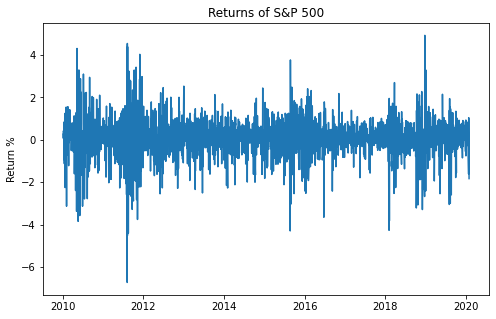

In [539]:
# add trace plot
plt.figure(figsize=(8,5))
plt.plot(df['Return'])
plt.ylabel("Return %")
plt.title('Returns of S&P 500')

We then continue the EDA phase by running autocorrelation and partial autocorrelation plots to visualize how previous returns (different lags) are correlated with one another. Recall, that because of properties of stationarity, the correlation and covariance at different points in time should be the same for the same gap in time regardless of the point in time. That is, it should be constant across the same gap in time and should depend only on the gap, *t-s* and not directly on *t*. As a result, we are able to construct the following plots based on different lagged values, h, and not dependent on the point in time t of the lag since they should persist for any starting point t in time. 

Note: as a result of using the log returns we lose the first data point since there is no intuitive way for the first point to have a return.

/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


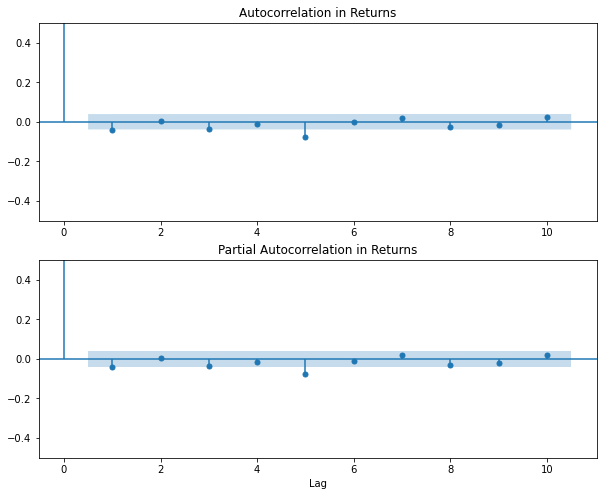

In [540]:
# Plot ACF and PACF
diff_ts = df['Return'].iloc[1:]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_ts, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5) 
ax1.set_title("Autocorrelation in Returns")
plot_pacf(diff_ts, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)  
ax2.set_xlabel("Lag")  
ax2.set_title("Partial Autocorrelation in Returns")

plt.show()

The above ACF and PACF plots are not indicative of the pattern that we would be interested in finding for the ACF or PACF to denote that there are ARCH and GARCH effects present. In particular, we would want to see that there are reasons why we believe the series in not independent and thus we can model the ARCH effects. 

To ensure that this is an independent series, or rather to test that it is not, we would remember that an independent series is one in which transformations of the series would themselves be independent. Thus, we can repeat the process above using the squared returns or the absolute returns. We will utilize the absolute returns, as this is generally utilized in financial data to diminsih the effects of outliers. 

/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


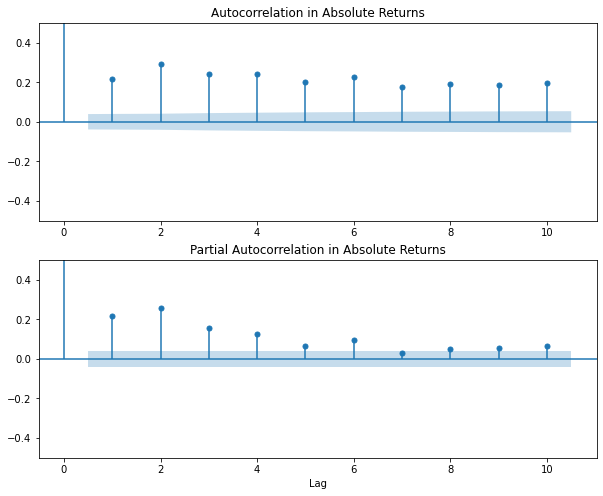

In [541]:
# Plot ACF and PACF of absolute returns
abs_returns = diff_ts.abs()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(abs_returns, ax=ax1, lags=10)
ax1.set_ylim(-.5, .5) 
ax1.set_title("Autocorrelation in Absolute Returns")
plot_pacf(abs_returns, ax=ax2, lags=10)
ax2.set_ylim(-.5, .5)  
ax2.set_title("Partial Autocorrelation in Absolute Returns")
ax2.set_xlabel("Lag")  
plt.show()

After the above transformation to absolute returns, we see that there is now a pattern indicative of ARCH and GARCH effects being present when looking at the significance of these ACF and PACF plots. We see that in the PACF there is not a big drop until about lag 4, which might indicate that we should have an order of p,q in that range (up to 4). For simplicity and illustration we will start with GARCH(1,1) before assessing and testing different model specifications. We will more formally test these effects using the Ljung Box test and McLeod-Li test for ARCH and GARCH effects. The nuances of these test statistics will be left out at the moment but the concept and hypothesis will be summarized. 

### Ljung-Box Test

The Ljung-Box test proposes the following null and alternative hypotheses to test for autocorrelation in a time series up to a certain lag: 

$H_0$: there is no autocorrelation in the time series up to a specified lag 

$H_a$:  there is autocorrelation in the time series up to the specified lag

While the above tests for autocorrelation presence in a time series, it serves a similar purpose in testing whether there are ARCH effects. This is because if there are ARCH effects then we would expect there to be autocorrelations between different lags. The result of the test is a test statistic of 1225.1 (p-value: < 0.001) and as a result we conclude that there is autocorrelation present in the time series, ARCH effects seem reasonable.

In [542]:
# perform Ljung-Box test
lb_test = acorr_ljungbox(abs_returns, lags=[10])

# print test results
print(f"Test statistic: {np.round(lb_test.iloc[0][0],3)}, p-value: {lb_test.iloc[0][1]}")


Test statistic: 1228.5, p-value: 1.0247817697197037e-257


### McLeod-Li Test

The McLeod-Li test proposes the following null and alternative hypotheses to test for white noise behavior in the residuals of the series: 

$H_0$:  there are no autoregressive conditional heteroscedasticity (ARCH) effects in the time series

$H_a$: there are ARCH effects in the time series

We thus first fit a model of GARCH(1,1) and then apply the McLeod-Li test to those residuals.
The result of the test is a p-value: < 0.001 and as a result we conclude that there are ARCH effects in the time series.

In [543]:
def mcleod_li_test(x, k):
    """
    Calculates the McLeod-Li test statistic for a time series with k lags.
    Returns the test statistic and its p-value.
    """
    n = len(x)
    x_sq = x ** 2
    x_sum = np.sum(x_sq)
    x_lag_sum = np.sum(x_sq[:-k])
    test_stat = n * (n + 2) * x_lag_sum / (x_sum ** 2)
    df = k
    p_value = 1 - chi2.cdf(test_stat, df)
    return test_stat, p_value
        

In [544]:
test_stat, p_value = mcleod_li_test(abs_returns, 50)
print("McLeod-Li test statistic: ", test_stat)
print("p-value: ", p_value)


McLeod-Li test statistic:  2929.746903643466
p-value:  0.0


## Fit Garch Model 

We fit the GARCH(1,1) model to the data below. We will use a training and test set split of 80/20% and ensure that the split is sequential, that is the last 20% of the data is used in the test set due to the temporal relationship of our time series data.

We use the funciton arch_model() from the arch package. We specify that the data is of mean zero and modeled with a GARCH process. We specify the arguments of p and q as 1,1 and choose not to rescale -- ie standardize the data. 

In [545]:
# fit model GARCH (1,1)
y_train, y_test = train_test_split(abs_returns, train_size= 0.8)

garch_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=1, rescale=False)
res_garch = garch_mod.fit()


Iteration:      1,   Func. Count:      5,   Neg. LLF: 4134.429961298091
Iteration:      2,   Func. Count:     14,   Neg. LLF: 3069.314515288495
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3281.666765833576
Iteration:      4,   Func. Count:     25,   Neg. LLF: 2412.0013206728854
Iteration:      5,   Func. Count:     30,   Neg. LLF: 2403.73012580069
Iteration:      6,   Func. Count:     34,   Neg. LLF: 2403.6991799095654
Iteration:      7,   Func. Count:     38,   Neg. LLF: 2403.696213567643
Iteration:      8,   Func. Count:     42,   Neg. LLF: 2403.6960783314817
Iteration:      9,   Func. Count:     46,   Neg. LLF: 2403.6960151168378
Iteration:     10,   Func. Count:     49,   Neg. LLF: 2403.6960151169287
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2403.6960151168378
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10


We recall the GARCH(p,q) model statement from above and provide estimates for the parameters as a result of our GARCH model fit: 

$X_t = \sigma_t\epsilon_t$ with $\sigma_t^2 = b_0 + \sum_{j=1}^{p} b_jX^2_{t-j} + \sum_{j=1}^{p} a_j\sigma^2_{t-j}$, where $\epsilon_t$ is IID(0,1) and $b_0, b_1, \dots, b_p, a_1, a_2 \dots, a_q \ne 0$

Our fitted model is then as follows:


​$\sigma_t^2 = (1.7162 \times 10^{-6}) + 0.1X_{t-1}^{2} + 0.88\sigma_{t-1}^{2}$


where $\sigma_t^2$ is the conditional variance at time $t$, $X_{t-1}^2$ is the squared return at time $t-1$, and $\sigma_{t-1}^2$ is the conditional variance at time $t-1$. 

The parameter estimates for the GARCH(1,1) model are $\beta_0 = 1.7162 \times 10^{-6}$, $b_1 = 0.1$, and $a_1 = 0.88$.


In [546]:
# model summary 
print(res_garch.summary()) 

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2403.70
Distribution:                  Normal   AIC:                           4813.39
Method:            Maximum Likelihood   BIC:                           4830.24
                                        No. Observations:                 2028
Date:                Sat, Apr 22 2023   Df Residuals:                     2028
Time:                        18:41:42   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0309  8.423e-03      3.667  2.450e-04 [1.

## Forecasting Volatility

[Include information about shorter window]

In [547]:
# forecast the test tset 
yhat = res_garch.forecast(horizon = y_test.shape[0], reindex=True)

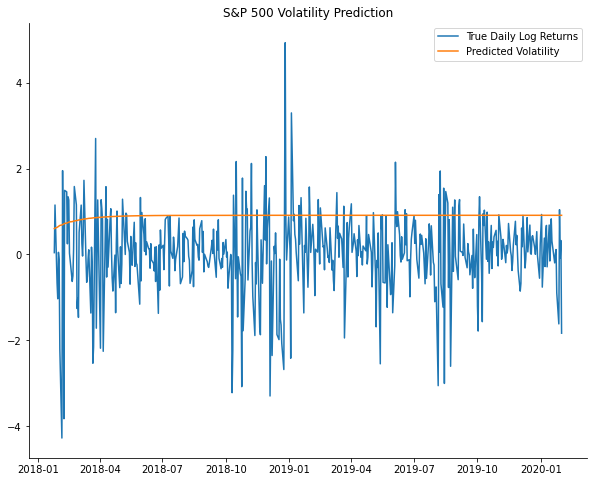

In [577]:

fig,ax = plt.subplots(figsize=(10,8))
ax.spines[['top','right']].set_visible(False)
# plot test set returns
plt.plot(diff_ts[-y_test.shape[0]:])
# plot volatility estimates for test set
plt.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
plt.title('S&P 500 Volatility Prediction')
plt.legend(['True Daily Log Returns', 'Predicted Volatility'])

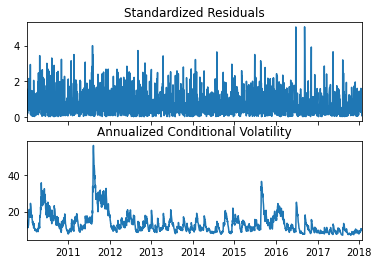

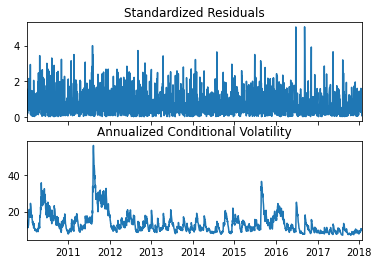

In [578]:
# decide whether to include 
res_garch.plot(annualize="D")

## Rolling Forecast

In [549]:
rolling_preds = []

for i in range(y_test.shape[0]):
    train = abs_returns[:-(y_test.shape[0]-i)]
    model = arch_model(train, p=1, q=1, rescale = False)
    model_fit = model.fit(disp='off')
    # one step ahead predictor
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_preds.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_preds = pd.Series(rolling_preds, index=y_test.index)


Text(0.5, 1.0, 'S&P 500 Rolling Volatility Prediction')

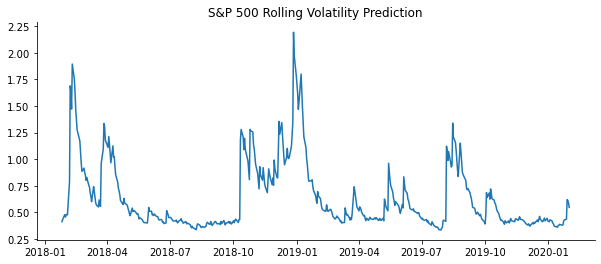

In [550]:
# plot of predicted test data volatility predictions 
fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_preds)
plt.title('S&P 500 Rolling Volatility Prediction')

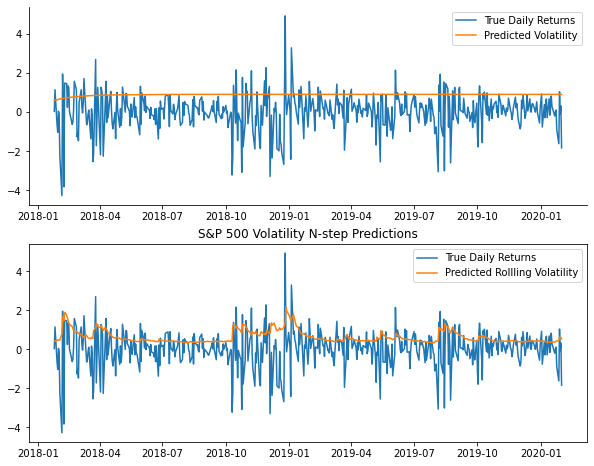

In [551]:
# Plot Rolling Prediction (1 step ahead and n step predictions)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.spines[['top','right']].set_visible(False)
ax1.plot(diff_ts[-y_test.shape[0]:])
ax1.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
ax1.legend(['True Daily Returns', 'Predicted Volatility'])


ax.spines[['top','right']].set_visible(False)
ax2.plot(diff_ts[-y_test.shape[0]:])
ax2.plot(y_test.index,rolling_preds)
ax2.set_title("S&P 500 Volatility N-step Predictions")
ax2.legend(['True Daily Returns', 'Predicted Rollling Volatility'])

## Model Diagnostics

To begin, we see that there are spikes in the predicted volatility in accordance with periods of higher variance of daily returns $-$ the spikes in returns and the predicted spikes in volatility line up. As well, we notice the ability to handle volatility clustering $-$ certain periods have lower variance followed by periods of large variance.

We now move forward with model diagnostics to ensure that our fitted model is valid. 

## Jarque-Bera Test

We use the Jarque-Bera test to check if the given data is normal. 

The formula for the test statistic is as follows: 

$JB = \frac{n}{6}[S^2 + \frac{1}{4}(K -3)^2]$, where n is the size of the data, S is the sample skeweness $-$ which measures the symmetry of the data relative to the mean $-$, and K is the sample kurtosis $-$ measuring the shape of ditribution especially the tails.

We know that the kurtosis of the normal distribution is 3, which is useful as a reference. Greater than 3, we have a sample that is heavier tailed than normal distribution. Less than 3, we have a sample that is ligher tailed than the normal distribution. 

We can gather the intuition, rather than hashing out all the math, that using the symmetry and shape of the sample realtive to known values for the normal distribution would help us arrive at the following hypothesis: 

$H_0$: The data has a normal distribution.

$H_a$: The data does not have a normal distribution.

The reason we are interested in the hypotheses above is that we make an assumption in the GARCH(p,q) model about the distribution of our errors, that if the model is specified correctly then they are normally distributed with mean 0 and constant variance. 

In [552]:
# Calculate the standardized residuals on the test data
std_resid = res_garch.resid / res_garch.conditional_volatility

# Perform Jarque-Bera test using scipy.stats
jb_test = jarque_bera(std_resid)
print("Jarque-Bera test statistic:", jb_test[0])
print("p-value:", jb_test[1])

Jarque-Bera test statistic: 1950.9209726398742
p-value: 0.0


## ACF of Standardized Residuals

The Jarque-Bera test showed us that we did not have standardized residuals which followed the normal distribution. We can see if $\epsilon_t$ is independent by looking at ACF plots of itself and its transformations, since transformations should also be insignificant if there is no correlation and thus independence in the residuals. 


/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


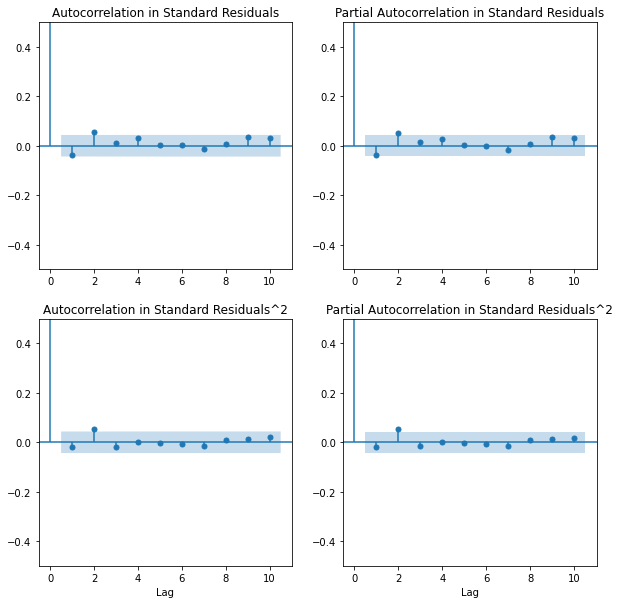

In [553]:
# Plot ACF and PACF
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
plot_acf(std_resid, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5) 
ax1.set_title("Autocorrelation in Standard Residuals")
plot_pacf(std_resid, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)  
ax2.set_title("Partial Autocorrelation in Standard Residuals")

plot_acf(std_resid**2, ax=ax3, lags=10)
ax3.set_ylim(-0.5, .5) 
ax3.set_xlabel("Lag") 
ax3.set_title("Autocorrelation in Standard Residuals^2")
plot_pacf(std_resid**2, ax=ax4, lags=10)
ax4.set_ylim(-0.5, .5)  
ax4.set_xlabel("Lag")  
ax4.set_title("Partial Autocorrelation in Standard Residuals^2")

plt.show()

## Normal QQ-Plots

Additionally, we can assess the normal QQ plots to ensure that the model we specify is appropriate. If the model is appropriate, we would expect the normal QQ plot of the residuals to fall along the diagonal line. For reference, the normal QQ plot of the returns did not elicit this behavoir, see below. For this reason, it was appropriate to believe that the true distribtion was not normally distributed and came from a heavier tailed distribution, which we know to be true of the market and we can inccorporate into our GARCH model. 


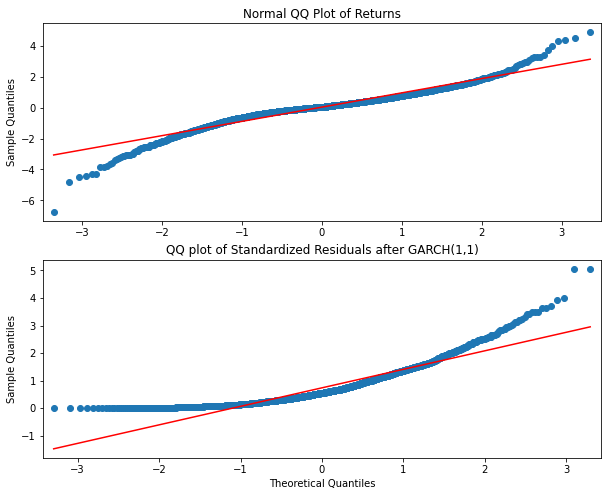

In [554]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
qqplot(diff_ts, line='s', ax = ax1)
fig.subplots_adjust(wspace=5.0)
ax1.set_xlabel("") 
ax1.set_title("Normal QQ Plot of Returns")
# change below to be of the residuals 
qqplot(std_resid, line='s', ax = ax2)
# ax2.set_ylim(-0.5, .5)  
ax2.set_title("QQ plot of Standardized Residuals after GARCH(1,1)")

plt.show()

## Garch with Student's t-Distribution

The student t distribution with different degrees of freedom results in a heavy-tailed distribution that retains a similarity to the normal distribution. As a result of our normal qq plots which are still exhibiting deviations from normality at the tails, we attempt to refit the model specification using a t-distribution and revisit some key parts of our results. 

Iteration:      5,   Func. Count:     33,   Neg. LLF: 4586.210201125645
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2350.182697748036
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2350.182697748035
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10


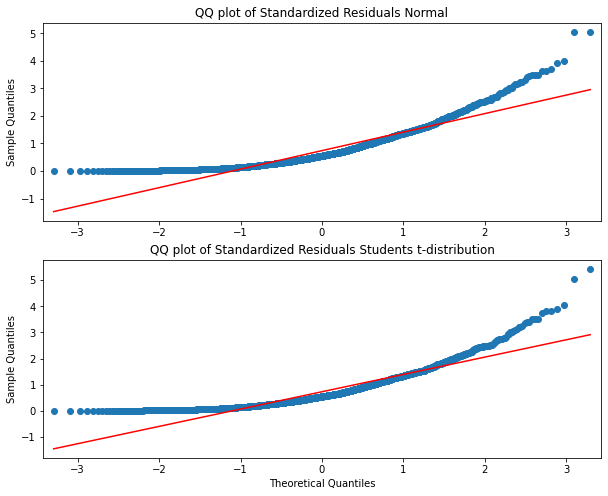

In [590]:
# garch(1,1) with students t 4.5 df
garch_t = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=1, dist = 'studentst', rescale=False)
res_gt = garch_t.fit(update_freq=5)

# forecast the test tset 
yhat_t = res_gt.forecast(horizon = y_test.shape[0], reindex=True)

# get residuals standardized
std_resid_t = res_gt.resid / res_gt.conditional_volatility

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
# std residuals of GARCH with normal 
qqplot(std_resid, line='s', ax = ax1)
ax1.set_title("QQ plot of Standardized Residuals Normal")
ax1.set_xlabel("")

qqplot(std_resid_t, line='s', ax = ax2)
ax2.set_title("QQ plot of Standardized Residuals Students t-distribution")

plt.show()

In [583]:
# rolling predictios- make into function earlier to perform better here

rolling_preds_t = []
for i in range(y_test.shape[0]):
    train = abs_returns[:-(y_test.shape[0]-i)]
    model = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=1, dist = 'studentst', rescale=False)
    model_fit = model.fit(disp='off')
    # one step ahead predictor
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_preds_t.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_preds_t = pd.Series(rolling_preds, index=y_test.index)

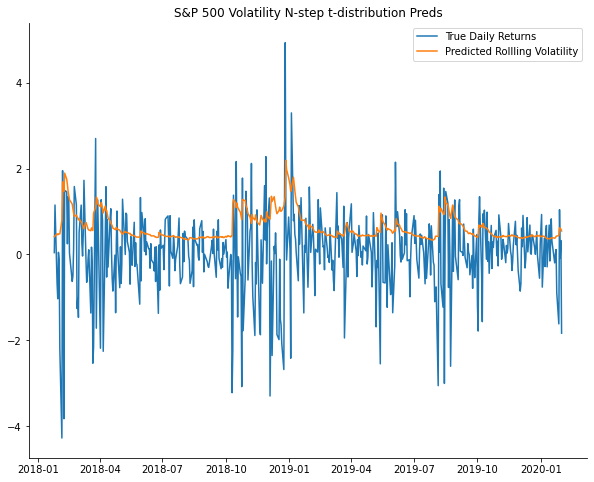

In [588]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.spines[['top','right']].set_visible(False)
plt.plot(diff_ts[-y_test.shape[0]:])
plt.plot(y_test.index,rolling_preds_t)
ax.set_title("S&P 500 Volatility N-step t-distribution Preds")
ax.legend(['True Daily Returns', 'Predicted Rollling Volatility'])

In [589]:
# check model summary log likelihood and AIC 
# previous normal dist: ll = -2403.7, aic = 4813.39, bic = 4830.24
print(res_gt.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2350.18
Distribution:      Standardized Student's t   AIC:                           4708.37
Method:                  Maximum Likelihood   BIC:                           4730.82
                                              No. Observations:                 2028
Date:                      Sat, Apr 22 2023   Df Residuals:                     2028
Time:                              19:11:31   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg